In [1]:
from netCDF4 import Dataset
from pyproj import Proj,transform
from mpl_toolkits.basemap import Basemap
import datetime
import progressbar as bar

### Notes:
#### Spatial Reference System 

***Problem:*** These data are likely in the HRAP grid (http://www.emc.ncep.noaa.gov/mmb/ylin/pcpanl/stage4/), which is hard to deal with. Basemap assumes data are WGS84 prior to projecting.

***Solution:*** Convert the included lat/lon arrays to WGS84, then define a Basemap projection and project the data to it. This is only really necessary to view the climatology in a geographically meaningful way. Found the proj4 strings for the HRAP grid here (http://polyploid.net/blog/?p=216), very similar to dealing with the WRF grids...

#### Units

Units are kg/m$^2$ or mm, which are equivalent, from metadata online

#### Time

***Problem:*** Time is in hours since a certain day.

***Solution:*** Convert to a datetime list using the certain date as an offset.

In [3]:
p1 = Proj('+proj=longlat +a=6371200 +b=6371200 +no_defs',preserve_units=True) # geographic projection for HRAP grid
p2 = Proj('+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +k=1 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +to_meter=4762.5 +no_defs')
#p2 = Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',preserve_units=True) # WGS84 geographic projection

In [4]:
p2.srs

'+units=m +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +k=1 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +to_meter=4762.5 +no_defs'

In [5]:
fl = './stage4_map_daily_20041220-20150107.nc'
ds = Dataset(fl,'r')

In [6]:
lats = np.array(ds.variables['lat'])
lons = np.array(ds.variables['lon'])

In [7]:
x,y = transform(p1,p2,lons,lats) # reproject the HRAP grid to WGS84

In [8]:
print(x[0,1]-x[0,0])
print(y[0,0]-y[0,1])

4763.39121173
0.22558971867


In [9]:
y

array([[-7617605.27806253, -7617605.50365225, -7617605.34278072, ...,
        -7617605.12385577, -7617605.31302914, -7617605.41428448],
       [-7612842.09612171, -7612842.16634463, -7612842.35207996, ...,
        -7612842.27416419, -7612842.36832883, -7612842.10252429],
       [-7608079.5786664 , -7608079.21785467, -7608079.52144202, ...,
        -7608079.48307639, -7608079.21157508, -7608079.3039064 ],
       ..., 
       [-3435710.41541418, -3435710.17191754, -3435710.28796134, ...,
        -3435710.1271334 , -3435710.26065358, -3435710.0803207 ],
       [-3430947.08183972, -3430947.13062162, -3430947.14592128, ...,
        -3430947.23412934, -3430947.53495996, -3430947.19227753],
       [-3426184.43801947, -3426184.39827461, -3426184.31603044, ...,
        -3426184.35639963, -3426184.49180844, -3426184.53572356]])

In [10]:
m,n = lons.shape

In [11]:
lons[0,1] - lons[0,0]

0.033729553

In [12]:
lons[0,-1] - lons[0,-2]

0.029785156

In [13]:
# setup the basemap for displaying the results of the calculations
M = Basemap(resolution='i',llcrnrlon = lons.min()+15, llcrnrlat = lats.min()+2, urcrnrlon = lons.max(),
            urcrnrlat = lats.max()-10, projection='aea',lat_1=29.5,lat_2=45.5,
            lon_0=-96,lat_0=23)

x,y = M(lons,lats)

In [14]:
x[0,1] - x[0,0]

3613.8684682580642

In [15]:
time = ds.variables['time']
print('Time Units: %s'%time.units)
timeoffset = time.units[-20:] # trip the string
strt = pd.to_datetime(timeoffset) # convert string into datetime object
time = np.array(ds.variables['time'])

def compute_time(time,offset):
    dt = datetime.timedelta(hours=time)
    time = offset+dt
    return str(time.date())

times = np.vectorize(compute_time)(time,strt)

Time Units: Hour since 2001-12-31T23:00:00Z


### Process Precip Climatology and Continuity 2005-2014

## Load the Processed Data

In [16]:
clim = np.load('./data/nexrad_iv_p_clim_2004_2014.npy')
cont = np.load('./data/nexrad_iv_cont_2004-2014.npy')

(0, 10)

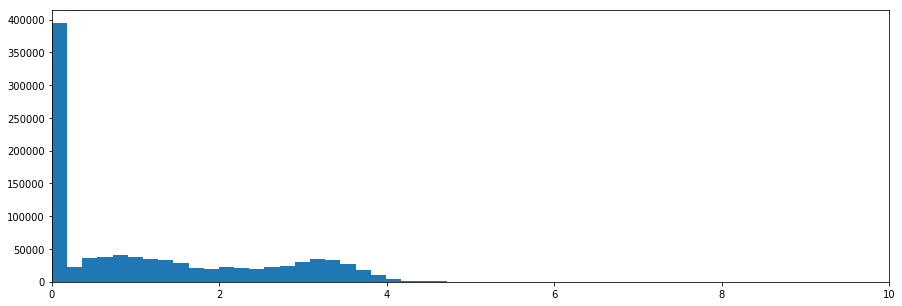

In [17]:
plt.figure(figsize=(15,5))
plt.hist(clim[np.isnan(clim)==0],1500);
plt.xlim(0,10)

In [18]:
clim = np.ma.masked_array(clim,(clim<=1) & (clim>=5))

In [19]:
ticks = np.arange(1,5.5,0.5)
labels = ['{:.1f}'.format(x) for x in list(ticks)]
labels[-1] = '>5.0'

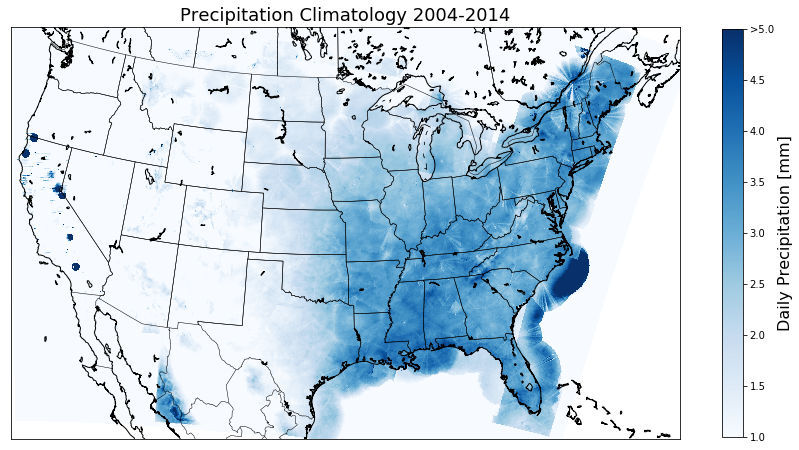

In [20]:
plt.figure(figsize=(15,10))
M.pcolormesh(x,y,clim,vmin=1,vmax=5,cmap='Blues')
M.drawstates()
M.drawcoastlines()
M.drawcountries()
cb = plt.colorbar(shrink=0.75)
cb.set_label('Daily Precipitation [mm]', fontsize=16)
plt.title('Precipitation Climatology 2004-2014', fontsize=18)
cb.set_ticks(ticks)
cb.set_ticklabels(labels)
plt.savefig('./figures/nexrad_iv_climatology.png',dpi=300, bbox_inches='tight')

In [21]:
cont_per = cont/cont.max()*100.

In [22]:
cont_ma = np.ma.masked_array(cont,cont==cont.max())

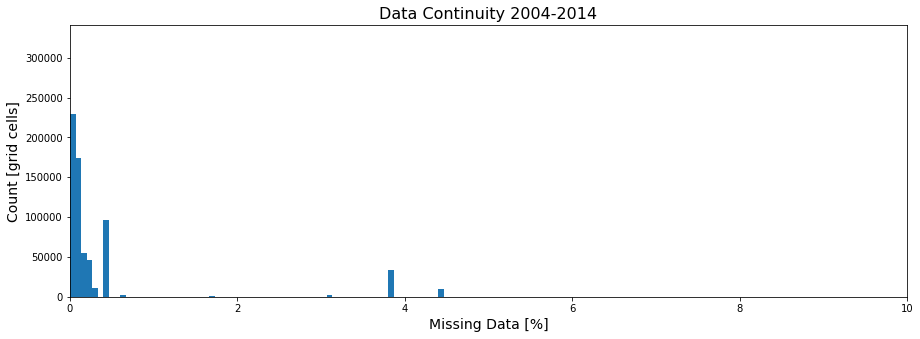

In [34]:
tmp = np.reshape(cont_per,(m*n))
plt.figure(figsize=(15,5))
plt.hist(tmp,1500);
plt.ylabel('Count [grid cells]', fontsize =14)
plt.xlabel('Missing Data [%]', fontsize = 14)
plt.xlim(0,10)
plt.title('Data Continuity 2004-2014', fontsize=16)

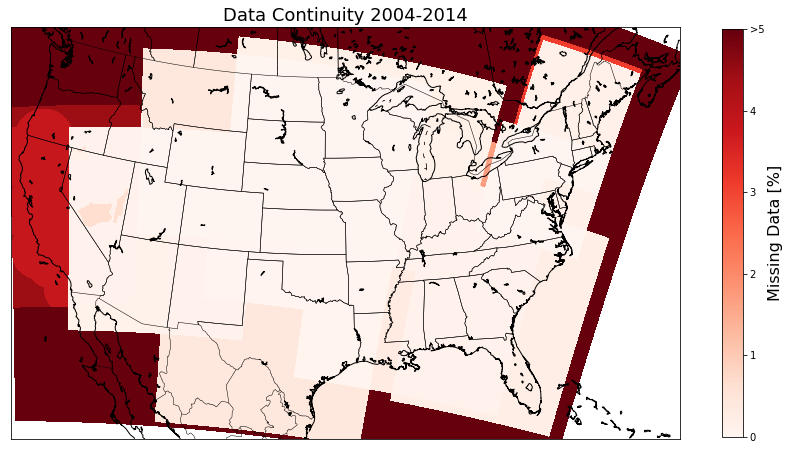

In [24]:
plt.figure(figsize=(15,10))
M.pcolormesh(x,y,cont_per,vmin=0,vmax=5,cmap='Reds')
M.drawstates()
M.drawcoastlines()
M.drawcountries()
cb = plt.colorbar(shrink=0.75)
plt.title('Data Continuity 2004-2014', fontsize=18)
cb.set_label('Missing Data [%]',fontsize=16)
cb.set_ticks(np.arange(0,6))
cb.set_ticklabels(['0','1','2','3','4','>5'])
plt.savefig('./figures/nexrad_iv_contiuity.png', dpi=300, bbox_inches='tight')

## Map Annual Precip from the Climatology and convert to mm

In [25]:
annual = clim*365.

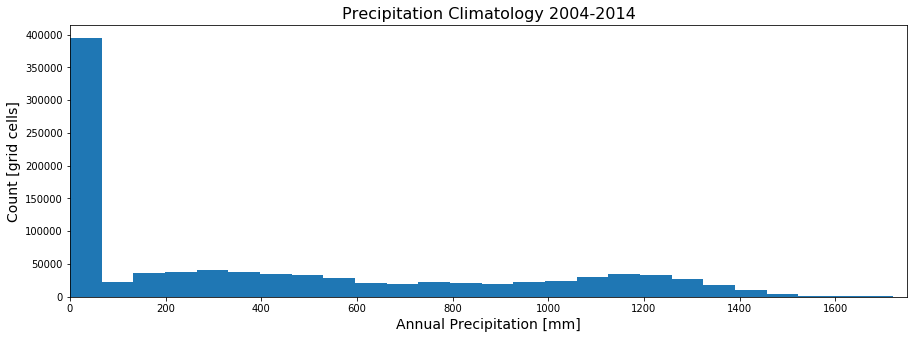

In [35]:
tmp = np.reshape(annual,(m*n))
plt.figure(figsize=(15,5))
plt.hist(tmp,1500);
plt.xlim(0,1750)
plt.xlabel('Annual Precipitation [mm]', fontsize = 14)
plt.ylabel('Count [grid cells]', fontsize = 14)
plt.title('Precipitation Climatology 2004-2014', fontsize=16)

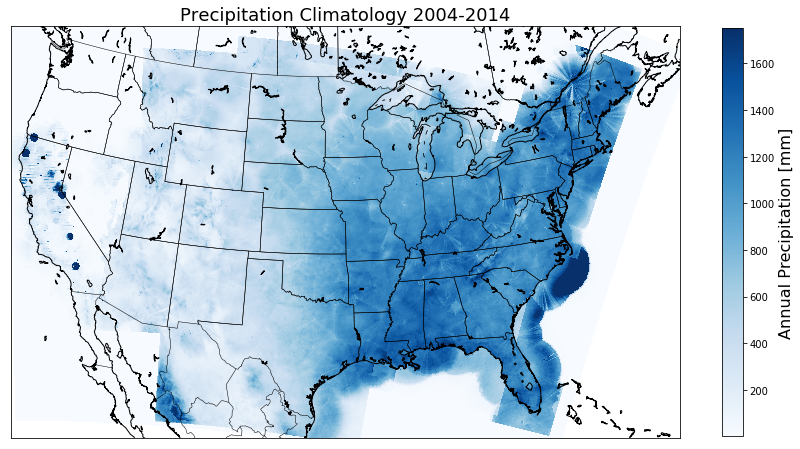

In [32]:
plt.figure(figsize=(15,10))
M.pcolormesh(x,y,annual,vmin=1,vmax=1750,cmap='Blues')
M.drawstates()
M.drawcoastlines()
M.drawcountries()
cb = plt.colorbar(shrink=0.75)
cb.set_label('Annual Precipitation [mm]', fontsize=16)
plt.title('Precipitation Climatology 2004-2014', fontsize=18)
#cb.set_ticks(ticks)
#cb.set_ticklabels(labels)
plt.savefig('./figures/nexrad_iv_climatology_annual.png',dpi=300, bbox_inches='tight')